In [1]:
# Third-party Library Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
from unidecode import unidecode
from bias_correction import BiasCorrection
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)
from scipy.stats import pearsonr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_columns', 100)

### 1. Read SCM & ERA data

<Axes: >

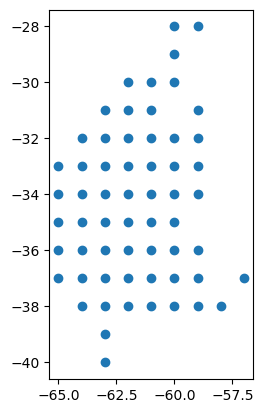

In [9]:
# Read ERA data
era_final = pd.read_csv("files/ERA/processed/era_final_features.csv")
era_raw = pd.read_csv("files/ERA/processed/era_tmean_rain_all_departments.csv").assign(model="ERA", init_month=12)

# Read and preprocess hindcast data from different climate models
c3s = pd.read_csv("c3s/data/c3s_hindcasts.csv")
nmme = pd.read_csv("nmme/data/nmme_hindcasts.csv")
#apcc = pd.read_csv("clik-apcc/data/apcc_hindcasts.csv")
scm = pd.concat([nmme, c3s], ignore_index=True).drop_duplicates()
scm = scm.rename(columns={"forecasted_month":"month"})
scm = scm.loc[(scm["year"].between(1993, 2016)) & (scm["init_month"].between(6, 11) & (scm["model"].isin(['GFDL', 'CCSM4', 'NASA', 'CMCC', 'DWD', 'ECMWF', 'METFR', 'UKMO', 'ECCC'])))].reset_index(drop=True)

scm = gpd.GeoDataFrame(scm, geometry=gpd.points_from_xy(scm["lon"], scm["lat"], crs="EPSG:4326"))

study_region = gpd.read_file("files/shapefiles/study_region.shp")
# directly spatial join takes too much time
coordinates = gpd.sjoin(scm[["geometry", "lat", "lon"]].drop_duplicates(), study_region).reset_index(drop=True)[["name", "lat", "lon"]]
scm = scm.merge(coordinates[["lat", "lon"]], on=["lat", "lon"], how="right")

# Store variables used throughout the notebook
climate_models = scm["model"].unique().tolist()
climate_models.sort()
crop_seasons = scm["year"].unique().tolist()
relevant_municipalities = list(set(["_".join(c.split("_")[1:3]) for c in era_final.columns if ("rain" in c) or ("tmean" in c)]))
weather_columns_final = [c for c in era_final.columns if ("rain" in c) or ("tmean" in c)]

# Extract raw weather columns based on basis expansion needed for final features
weather_columns_raw = []
new_dict = dict(zip(["tmean", "rain"], [dict.fromkeys(["_".join(c.split("_")[1:3]) for c in weather_columns_final if ("tmean" in c)]),
                                        dict.fromkeys(["_".join(c.split("_")[1:3]) for c in weather_columns_final if ("rain" in c)])]))
for var in new_dict:
    for loc in new_dict[var]:
        new_dict[var][loc] = list(set([int(c.split("_")[-1]) for c in weather_columns_final if (var in c) and (loc in c)]))
        for month in new_dict[var][loc]:
            weather_columns_raw.append("{}_{}_{}".format(var, loc, month))
            
era_raw = era_raw.loc[:, ["year", "model", "init_month"] + weather_columns_raw]

# Display a random sample from the processed hindcast data
scm.sample(2)

scm[["lat", "lon", "geometry"]].drop_duplicates().plot()

In [11]:
relevant_municipalities

['-38_-62', '-31_-61', '-36_-62']

### 3. Bring SCM hindcasts into feature structure

In [13]:
scm

,model,year,init_month,month,rain,tmean,lat,lon,geometry
0,GFDL,1993,6,9,0.001588,13.175134,-40.0,-63.0,POINT (-63.00000 -40.00000)
1,GFDL,1993,6,10,0.001645,16.745554,-40.0,-63.0,POINT (-63.00000 -40.00000)
2,GFDL,1993,6,11,0.001329,20.360895,-40.0,-63.0,POINT (-63.00000 -40.00000)
3,GFDL,1993,7,9,0.001833,12.802850,-40.0,-63.0,POINT (-63.00000 -40.00000)
4,GFDL,1993,7,10,0.001885,16.201349,-40.0,-63.0,POINT (-63.00000 -40.00000)
...,...,...,...,...,...,...,...,...,...
194395,ECCC,2016,9,10,0.005022,21.997308,-28.0,-59.0,POINT (-59.00000 -28.00000)
194396,ECCC,2016,9,11,0.003307,24.115381,-28.0,-59.0,POINT (-59.00000 -28.00000)
194397,ECCC,2016,10,10,0.004363,21.963373,-28.0,-59.0,POINT (-59.00000 -28.00000)
194398,ECCC,2016,10,11,0.003581,26.029199,-28.0,-59.0,POINT (-59.00000 -28.00000)


In [19]:
li =[]
for m in relevant_municipalities:
    df = scm.loc[(scm["lat"] == int(m.split("_")[0])) & (scm["lon"] == int(m.split("_")[1]))].pivot_table(
        index=["model", "year", "init_month", "lat", "lon"],
        columns=["month"],
        values=["tmean", "rain"]
    ).reset_index()
    #df.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in df.columns]
    #df.columns = [c.strip("_") for c in df.columns]
    df = df.set_index(["model", "year", "init_month", "lat", "lon"])
    li.append(df)

scm_pivot = pd.concat(li, axis=1, join="outer").reset_index().sort_values(by=["model", "year", "init_month", "lat", "lon"]).reset_index(drop=True)
scm_pivot.head(2)
#scm_pivot = scm_pivot.loc[:, ["year", "model", "init_month"] + ["lat", "lon"] + weather_columns_raw]
#scm_pivot.sample(3)

/var/folders/wz/1l02swfn32g2q18shkm7rzsr0000gn/T/ipykernel_12932/1571399239.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  scm_pivot = pd.concat(li, axis=1, join="outer").reset_index().sort_values(by=["model", "year", "init_month", "lat", "lon"]).reset_index(drop=True)


model  year init_month   lat   lon     rain                      \
month                                            9        10        11   
0      CCSM4  1993          6 -38.0 -62.0  0.00142  0.002042  0.002258   
1      CCSM4  1993          6 -36.0 -62.0      NaN       NaN       NaN   

           tmean                       rain         tmean              rain  \
month          9         10         11    9  10  11     9  10  11         9   
0      12.631677  16.816812  20.450403  NaN NaN NaN   NaN NaN NaN       NaN   
1            NaN        NaN        NaN  NaN NaN NaN   NaN NaN NaN  0.001302   

                               tmean                       
month        10        11          9         10        11  
0           NaN       NaN        NaN        NaN       NaN  
1      0.002058  0.002605  14.439325  18.668695  22.27746

### 4. Adjust Bias

In [390]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """apply bias-adjustment to monthly values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    adjusted_models = []
    for model in climate_models:
        adjusted_init_months = []
        for month in predicted["init_month"].unique().tolist():
            adjusted_cols = []
            for col in weather_columns_raw:
                adjusted_years = []
                for year in crop_seasons:
                    observations_used_as_reference = observed.loc[(observed["model"] == "ERA") & (observed["year"] != year), col]
                    hindcast_used_as_reference = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month), col]
                    hindcast_to_be_adjusted = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), col].copy()
                    y = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), ["model", "year", "init_month"]].copy()
                    # Perform bias-adjustment 
                    if int(col.split("_")[-1]) >= month:
                        bc_col = BiasCorrection(observations_used_as_reference, hindcast_used_as_reference, hindcast_to_be_adjusted)
                        hindcast_to_be_adjusted = bc_col.correct(method=correction_method)
                    hindcast_to_be_adjusted = pd.concat([y, hindcast_to_be_adjusted], axis=1)
                    adjusted_years.append(hindcast_to_be_adjusted)
                adjusted_years = pd.concat(adjusted_years)
                adjusted_cols.append(adjusted_years)
            adjusted_cols = pd.concat(adjusted_cols, axis=1)
            adjusted_cols = adjusted_cols.loc[:,~adjusted_cols.columns.duplicated()]
            adjusted_init_months.append(adjusted_cols)
        adjusted_init_months = pd.concat(adjusted_init_months)
        adjusted_models.append(adjusted_init_months)
    adjusted_models = pd.concat(adjusted_models).sort_values(by=["model", "year", "init_month"])
    return adjusted_models

In [391]:
scm_bias_adjusted = adjust_bias(era_raw, scm_pivot, "basic_quantile")
scm_bias_adjusted.sample(3)

,model,year,init_month,tmean_santa fe san justo_10,tmean_santa fe san justo_11,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_11,tmean_entre rios nogoya_9,tmean_entre rios nogoya_10,tmean_buenos aires hipolito yrigoyen_11,rain_santa fe san justo_10,rain_santa fe san justo_11,rain_santa fe las colonias_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9,rain_buenos aires hipolito yrigoyen_11,rain_entre rios nogoya_10
16564,UKMO,2011,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000961,NaN,NaN,NaN,NaN,NaN
11590,METFR,2002,7,18.902166,22.733121,NaN,NaN,NaN,NaN,NaN,0.001675,0.001207,0.001665,NaN,NaN,NaN,NaN,NaN
9676,JMA,2002,9,NaN,NaN,NaN,NaN,15.151318,17.2332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00241


### 5. Standardize and Basis Expansion

Standardization is done through the LOYO-CV scheme, separately for each model.

In [392]:
def standardize_loyo(scm_df, era_df):
    scm_df = scm_df.copy()
    era_df = era_df.copy()
    standardized_data = []
    for model in scm_df["model"].unique():
        standardized_data_init_month = []
        for month in scm_df["init_month"].unique():
            standardized_data_current_scm = []
            for year in list(range(1993, 2017)):
                # split
                features_used_for_standardization = era_df.loc[(era_df["year"] != year), [c for c in era_df.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                features_to_standardize = scm_df.loc[(scm_df["year"] == year) & (scm_df["model"] == model) & (scm_df["init_month"] == month), [c for c in scm_df.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                #print(features_used_for_standardization)
                # standardize
                features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
                # bring it together
                year_model_init_month = scm_df.loc[(scm_df["year"] == year) & (scm_df["model"] == model) & (scm_df["init_month"] == month), ["year", "model", "init_month"]].reset_index(drop=True)
                standardized_df = pd.concat([year_model_init_month, features_standardized], axis=1)
                standardized_df.loc[:, [c for c in [l for l in standardized_df.columns if ("tmean" in l) or ("rain" in l)] if (int(c.split("_")[-1]) < month)]] = np.nan
                standardized_data_current_scm.append(standardized_df)
            current_scm_standardized = pd.concat(standardized_data_current_scm, ignore_index=True)
            standardized_data_init_month.append(current_scm_standardized)
        standardized_data_init_month = pd.concat(standardized_data_init_month)
        standardized_data.append(standardized_data_init_month)
    df_standardized = pd.concat(standardized_data)
    return df_standardized

def apply_basis_expansion(scm_df, era_raw_df, era_final_df, final_features):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(scm_df, era_raw_df)
    df_standardized = df_standardized.sort_values(by=["model", "year", "init_month"]).set_index(["model", "year", "init_month"])

    for col in final_features:
        type_of_expansion = col.split("_")[0]
        location = col.split("_")[1]
        month = col.split("_")[2]
        
        if type_of_expansion == "tmeansquared":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            df_standardized[col] = tmean.mul(tmean)
        if type_of_expansion == "rainsquared":
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain.mul(rain)
        if type_of_expansion == "tmeanrain":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain * tmean.values
    
    df_standardized = df_standardized[final_features].reset_index()
    
    # standardize expanded features again
    df_standardized = standardize_loyo(df_standardized, era_final_df)
    df_standardized = df_standardized.groupby(["model", "year", "init_month"]).mean()[final_features].reset_index()
    
    return df_standardized

In [393]:
scm_basis_expansion = apply_basis_expansion(scm_bias_adjusted, era_raw, era_final, weather_columns_final)
scm_basis_expansion.sample(3)

,model,year,init_month,tmeanrain_santa fe san justo_11,rainsquared_santa fe las colonias_11,tmeanrain_buenos aires coronel suarez_9,tmeansquared_entre rios nogoya_9,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_entre rios nogoya_10,tmeansquared_buenos aires coronel suarez_11,tmeanrain_buenos aires hipolito yrigoyen_11,tmeanrain_buenos aires coronel suarez_11,rainsquared_santa fe san justo_11,tmeanrain_santa fe san justo_10
1085,GFDL,2005,11,0.196340,0.064834,NaN,NaN,NaN,NaN,-0.002649,-0.003893,0.113470,0.073614,NaN
246,CCSM4,2010,6,0.824231,2.062160,0.629442,1.081844,1.205148,1.154077,0.094604,0.633119,0.670759,1.694862,1.175055
668,DWD,2008,8,-0.263398,0.197893,0.570301,0.803678,0.100883,0.161946,0.475135,0.145548,-0.115968,0.104372,0.311932


### 5. Fill past months with ERA data

In [423]:
scm_yield = scm_basis_expansion.merge(era_final[["year", "yield anomaly [%]"]], on="year", how="left")
scm_yield = scm_yield[era_final.columns].set_index("year").combine_first(era_final.set_index("year")).reset_index()
# Concat ERA with init_month = 12  
scm_era = pd.concat([scm_yield, era_final], ignore_index=True)
scm_era = scm_era.drop_duplicates().reset_index(drop=True)
scm_era = scm_era.sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)
# Preview
scm_era.sample(5)

,year,model,init_month,yield anomaly [%],tmeanrain_santa fe san justo_11,rainsquared_santa fe las colonias_11,tmeanrain_buenos aires coronel suarez_9,tmeansquared_entre rios nogoya_9,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_entre rios nogoya_10,tmeansquared_buenos aires coronel suarez_11,tmeanrain_buenos aires hipolito yrigoyen_11,tmeanrain_buenos aires coronel suarez_11,rainsquared_santa fe san justo_11,tmeanrain_santa fe san justo_10
1062,1998,GFDL,6,-0.006932,1.222684,0.692998,0.253240,3.122325,-0.058630,1.161511,0.360696,0.341711,0.671906,1.112904,1.389474
860,2016,ECCC,8,0.066009,-0.015743,0.673668,0.047852,0.368658,-0.043858,-0.068516,-0.018208,0.182873,0.205554,0.840659,-0.052513
671,2008,DWD,11,-0.290659,-3.318960,1.069175,0.425418,-0.779128,-0.641597,-0.545712,3.340834,-0.426648,-0.836616,1.161638,-0.042816
647,2004,DWD,11,0.093354,0.400071,0.642287,0.310226,0.781078,-0.285739,0.003343,1.090568,0.316700,-0.041376,0.318147,0.049875
2164,2013,UKMO,10,-0.161119,-0.114209,1.301206,-0.858534,-0.680449,-0.533631,-0.058713,-0.032378,0.176892,0.377402,0.983250,-0.109965


### 6. Calculate performance metrics

#### 6.1 Out-of-sample R<sup>2</sup>

In [424]:
def r2_by_feature_init_month_and_scm(init_month, climate_models, scm_df, features):
    scm = scm_df.loc[scm_df["model"] != "ERA"].reset_index().set_index(["model", "year", "init_month"]).copy()
    era = scm_df.loc[scm_df["model"] == "ERA"].reset_index().copy()
    
    model_to_col_to_r2 = dict.fromkeys(climate_models)
    loyo_mean = (era[features].sum() - era[features]) / (era.shape[0] - 1)
    
    for model in climate_models:
        forecasted_scm = scm.xs(init_month, level=2, drop_level=True).xs(model, level=0, drop_level=True)[features]
        
        ss_total = mse(era[features], loyo_mean, multioutput="raw_values")
        ss_model = mse(era[features], forecasted_scm, multioutput="raw_values")
        
        current_r2 = 1 - ( ss_model / ss_total )
        model_to_col_to_r2[model] = dict(zip(features, current_r2))

    model_to_col_to_r2 = pd.DataFrame(model_to_col_to_r2).assign(init_month=init_month)
    model_to_col_to_r2[model_to_col_to_r2 < 0] = 0
    return model_to_col_to_r2

r2_6 = r2_by_feature_init_month_and_scm(6, climate_models, scm_era, weather_columns_final)
r2_7 = r2_by_feature_init_month_and_scm(7, climate_models, scm_era, weather_columns_final)
r2_8 = r2_by_feature_init_month_and_scm(8, climate_models, scm_era, weather_columns_final)
r2_9 = r2_by_feature_init_month_and_scm(9, climate_models, scm_era, weather_columns_final)
r2_10 = r2_by_feature_init_month_and_scm(10, climate_models, scm_era, [c for c in weather_columns_final if ("_9" not in c)])
r2_11 = r2_by_feature_init_month_and_scm(11, climate_models, scm_era, [c for c in weather_columns_final if ("_11" in c)])

r2_by_init = pd.concat([r2_6, r2_7, r2_8, r2_9, r2_10, r2_11])

#### 6.2 Bias, MAE, correlation

In [425]:
# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
scm_models = [c for c in scm_era.model.unique().tolist() if c != "ERA"]
weather_columns = [c for c in scm_era.columns if ("_11" in c) or ("_10" in c) or ("_9" in c)]

In [426]:
scm_bias = scm_era.loc[scm_era["model"].isin(scm_models)]
era_bias = scm_era.loc[scm_era["model"] == "ERA"].set_index("year")[weather_columns]

all_metrics = []
for model in scm_models:
    for month in list(range(6,12)):
        current_scm = scm_bias.loc[(scm_bias["model"] == model) & (scm_bias["init_month"] == month)].set_index("year")
        # MAE
        current_scm_mae = abs(current_scm[weather_columns] - era_bias)
        current_scm_mae.loc[:, [c for c in weather_columns if int(c.split("_")[-1]) < month]] = np.nan
        # Pearson's r
        X = (current_scm[weather_columns] - current_scm[weather_columns].mean(axis=0)) / current_scm[weather_columns].std(axis=0)
        Y = (era_bias - era_bias.mean(axis=0)) / era_bias.std(axis=0)
        pearson_r = np.dot(X.T, Y) / X.shape[0]
        pearson_r = pearson_r.diagonal()
        current_scm_r = pd.DataFrame(data={"model":[model], "init_month":[month], "metric":["pearson"]})
        current_scm_r[weather_columns] = pearson_r
        # Bias
        current_scm_bias = current_scm[weather_columns] - era_bias
        current_scm_bias.loc[:, [c for c in weather_columns if int(c.split("_")[-1]) < month]] = np.nan
        
        current_scm_info = current_scm[['model', 'init_month', 'yield anomaly [%]']]
        
        current_scm_mae = pd.concat([current_scm_info, current_scm_mae], axis=1).groupby(['model', 'init_month'])[weather_columns].mean().reset_index(drop=False).assign(metric="MAE")
        current_scm_bias = pd.concat([current_scm_info, current_scm_bias], axis=1).groupby(['model', 'init_month'])[weather_columns].mean().reset_index(drop=False).assign(metric="Bias")
        current_scm_metrics = pd.concat([current_scm_mae, current_scm_bias], axis=0)
        current_scm = pd.concat([current_scm_metrics, current_scm_r], axis=0)
        #current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1)[['model', 'init_month']+weather_columns]
        all_metrics.append(current_scm)
all_metrics = pd.concat(all_metrics)
all_metrics = all_metrics.set_index(["model", "init_month", "metric"]).stack(dropna=False).reset_index()
all_metrics.columns = ["model", "init_month", "metric", "feature", "value"]

all_metrics["type"] = all_metrics["feature"].apply(lambda x: x.split("_")[0])

feature_order_hard_coded = ["rainsquared", "tmeansquared", "tmeanrain"
 ]

all_metrics["type"] = pd.Categorical(all_metrics["type"], 
                      categories=feature_order_hard_coded,
                      ordered=True)

In [427]:
metric_r = all_metrics.groupby(["model", "init_month", "metric"])["value"].mean().reset_index()
metric_r = metric_r.loc[metric_r["metric"] == "pearson", ["model", "init_month", "value"]].pivot(index="model", columns="init_month", values="value")

metric_mae = all_metrics.groupby(["model", "init_month", "metric"])["value"].mean().reset_index()
metric_mae = metric_mae.loc[metric_mae["metric"] == "MAE", ["model", "init_month", "value"]].pivot(index="model", columns="init_month", values="value")

metric_bias = all_metrics.groupby(["model", "init_month", "metric"])["value"].mean().reset_index()
metric_bias = metric_bias.loc[metric_bias["metric"] == "Bias", ["model", "init_month", "value"]].pivot(index="model", columns="init_month", values="value")

metric_r2 = r2_by_init.groupby("init_month").mean().transpose()

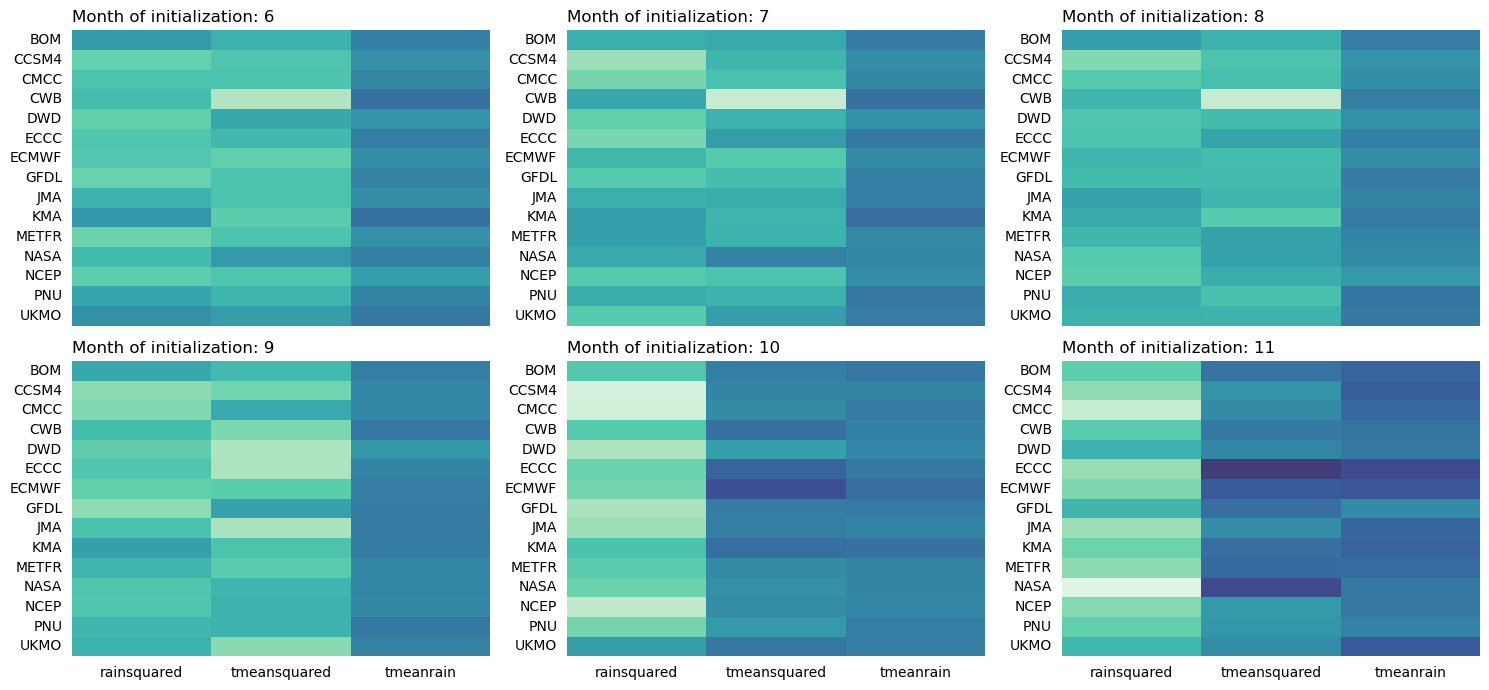

In [428]:
fig, axs = plt.subplots(2, 3, figsize=(15,7), sharex=True)
axs = axs.ravel()

data = all_metrics.loc[all_metrics["metric"] == "MAE"]
data = data.groupby(["model", "init_month", "type"])["value"].mean().reset_index()
for ax, month in zip(axs, list(range(6, 12))):
    data_plot = data.loc[data["init_month"] == month]
    data_plot = data_plot.pivot(index="model", columns="type", values="value")
    #print(data_plot)
    if month != 12:
        sns.heatmap(data_plot, vmin=0.3, vmax=1.3, cmap="mako", ax=ax, cbar=False)
    elif month == 12:
        sns.heatmap(data_plot, vmin=0.3, vmax=1.3, cmap="mako", ax=ax, cbar=True)
    ax.tick_params(left=False, bottom=False)
    ax.set_title("Month of initialization: {}".format(month), loc="left")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0, ha='center')
    ax.set_xlabel("")
    ax.set_ylabel("")

  
plt.tight_layout()
#plt.savefig("files/figures/figure3.svg")
plt.show()



In [436]:
im_to_weight = {6: 1/6, 7: 1/5, 8:1/4, 9:1/3, 10:1/2, 11:1/1}
all_metrics.loc[(all_metrics["metric"] == "MAE"), "value_scaled"] = all_metrics.loc[(all_metrics["metric"] == "MAE"), ["init_month", "value"]].apply(lambda x: im_to_weight[x[0]]*x[1], axis=1)
feature_skillful_model = (all_metrics.loc[(all_metrics["metric"] == "MAE") & (all_metrics["init_month"].isin([9, 10, 11]))]
 .groupby(["model", "type"])["value_scaled"].mean().reset_index()
 .groupby(["type"])[["model", "value_scaled"]].apply(lambda grp: grp.nsmallest(5, 'value_scaled')).reset_index()
                                            .groupby(["type"])["model"].apply(lambda n: sorted(list(n)))
                                            .reset_index().set_index("type")
                                            .to_dict()["model"])

In [437]:
feature_skillful_model

{'rainsquared': ['BOM', 'CWB', 'DWD', 'KMA', 'UKMO'],
 'tmeansquared': ['ECCC', 'ECMWF', 'GFDL', 'KMA', 'NASA'],
 'tmeanrain': ['BOM', 'ECCC', 'ECMWF', 'KMA', 'UKMO']}

In [438]:
scm_era_modified = scm_era.loc[scm_era["init_month"] != 12].copy()

In [439]:
for col in [c for c in scm_era_modified.columns if ("rain" in c) or ("tmean" in c)]:
    scm_era_modified.loc[:, col] =  scm_era_modified.loc[scm_era_modified["init_month"] < 12, ["model", col]].apply(lambda x: np.nan if x[0] not in feature_skillful_model[col.split("_")[0]] else x[1], axis=1)

In [440]:
scm_era_modified = scm_era_modified.groupby(["year", "init_month"])[[c for c in scm_era_modified.columns if c not in ["year", "init_month", "model"]]].mean().reset_index().assign(model="5-member-MME")

In [441]:
scm_era = pd.concat([scm_era, scm_era_modified], ignore_index=True)

In [442]:
scm_era

,year,model,init_month,yield anomaly [%],tmeanrain_santa fe san justo_11,rainsquared_santa fe las colonias_11,tmeanrain_buenos aires coronel suarez_9,tmeansquared_entre rios nogoya_9,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_entre rios nogoya_10,tmeansquared_buenos aires coronel suarez_11,tmeanrain_buenos aires hipolito yrigoyen_11,tmeanrain_buenos aires coronel suarez_11,rainsquared_santa fe san justo_11,tmeanrain_santa fe san justo_10
0,1993,BOM,6,-0.046171,0.725669,0.712881,0.682400,1.347749,0.189884,0.561681,0.552183,0.343956,0.405741,0.692175,0.950283
1,1993,BOM,7,-0.046171,0.580184,0.444568,0.425965,1.191490,0.006956,0.425341,0.604599,0.291716,0.143867,0.429277,0.433724
2,1993,BOM,8,-0.046171,0.021645,-0.009407,0.538691,1.612518,0.072392,0.577047,0.751893,0.654474,0.446544,-0.030927,0.670197
3,1993,BOM,9,-0.046171,0.758047,0.543646,0.329591,1.970455,-0.087578,0.493220,0.609203,0.376360,0.245515,0.539012,0.656608
4,1993,BOM,10,-0.046171,0.551518,0.356188,0.507882,1.273177,-0.504002,0.560554,0.207151,0.395699,0.122295,0.374505,0.680866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2016,5-member-MME,7,0.066009,0.107587,0.652779,-0.106246,0.525779,0.128967,-0.093641,0.211175,-0.144099,-0.265052,0.670992,0.105675
2324,2016,5-member-MME,8,0.066009,0.093425,0.381996,-0.092733,0.738880,0.041548,-0.126907,0.104093,0.060779,0.027697,0.384197,-0.033161
2325,2016,5-member-MME,9,0.066009,0.243374,0.447298,-0.041443,0.977880,0.014278,0.003591,0.095613,-0.096394,-0.071471,0.451348,0.109670
2326,2016,5-member-MME,10,0.066009,-0.155771,0.457051,0.453573,-0.240806,-0.437576,-0.075510,0.240724,-0.164868,-0.178655,0.486354,0.043912


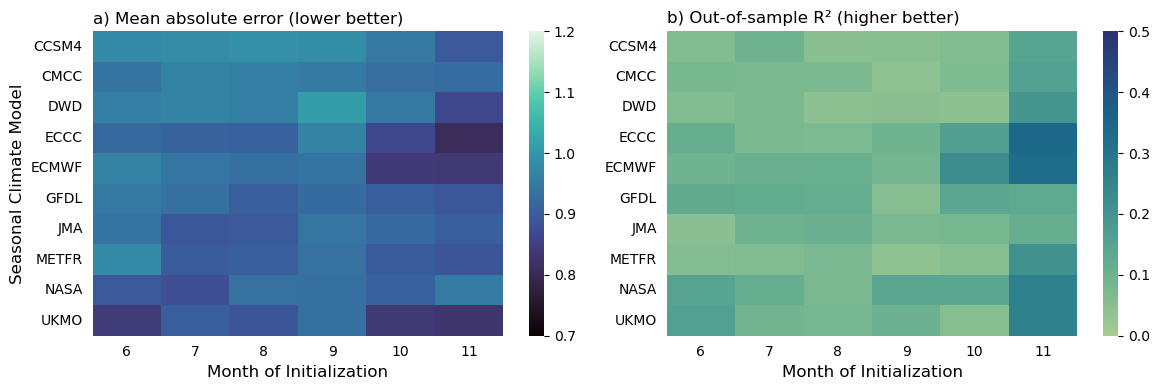

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = axs.ravel()

#sns.heatmap(metric_bias, vmin=-0.5, vmax=0.5, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), ax=axs[0])
#axs[0].set_ylabel("Seasonal Climate Model", size=11);
#axs[0].set_xlabel("");
#axs[0].set_title("a) Mean error (close to zero better)", loc="left", size=11);

sns.heatmap(metric_mae, vmin=0.7, vmax=1.2, cmap="mako", ax=axs[0])
axs[0].set_ylabel("Seasonal Climate Model", size=12);
axs[0].set_xlabel("Month of Initialization", size=12);
axs[0].tick_params(left=False, bottom=False)
axs[0].set_title("a) Mean absolute error (lower better)", loc="left", size=12);

#sns.heatmap(metric_r, vmin=0, vmax=1, cmap="crest", ax=axs[2])
#axs[2].set_ylabel("Seasonal Climate Model", size=11);
#axs[2].set_xlabel("Month of Initialization", size=11);
#axs[2].set_title("c) Pearson's correlation coefficient (higher better)", loc="left", size=11);

sns.heatmap(metric_r2, vmin=0, vmax=0.5, cmap="crest", ax=axs[1])
axs[1].set_ylabel("");
axs[1].set_xlabel("Month of Initialization", size=12);
axs[1].tick_params(left=False, bottom=False)
axs[1].set_title("b) Out-of-sample R\u00b2 (higher better)", loc="left", size=12);

plt.tight_layout()

#plt.savefig("files/figures/figure3.png")

## EXPORT

In [443]:
scm_era.to_csv("files/ERA/processed/era_scm_final_features.csv", index=False)